In [85]:
from typing import Callable
from os import makedirs
from os.path import join
import numpy as np
import pandas as pd
from verma_net_radiation_sensitivity.verma_net_radiation_sensitivity import process_verma_net_radiation_table
from PTJPL_sensitivity import process_PTJPL_table
from SEBAL import process_SEBAL_G_table
from sensitivity import joint_perturbed_run, repeat_rows
import matplotlib.pyplot as plt
from scipy.stats import mstats, gaussian_kde
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import mpl_scatter_density 
from matplotlib.colors import LinearSegmentedColormap
from evapotranspiration_conversion import process_daily_ET_table

In [86]:
input_df = pd.read_csv("calval_final_50_PTJPL_inputs.csv")
input_df = input_df[input_df.fAPARmax != 0]

In [87]:
def process_verma_PTJPL_table(input_df: pd.DataFrame) -> pd.DataFrame:
    return process_PTJPL_table(process_verma_net_radiation_table(input_df))

def process_ET_table(input_df: pd.DataFrame) -> pd.DataFrame:
    return process_daily_ET_table(process_PTJPL_table(process_verma_net_radiation_table(input_df)))

def process_ET_table_sebal(input_df: pd.DataFrame) -> pd.DataFrame:
    return process_daily_ET_table(process_PTJPL_table(process_SEBAL_G_table(input_df)))

Text(0, 0.5, 'verma Rn')

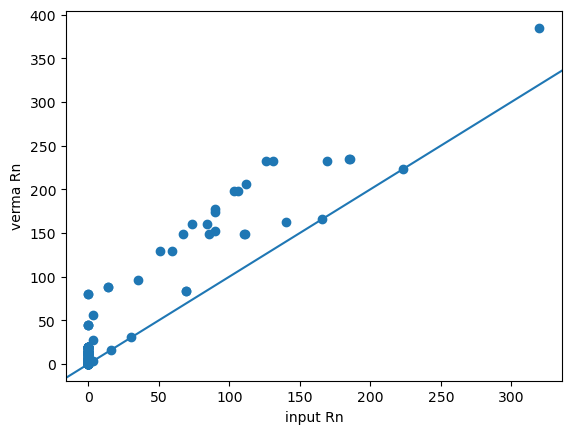

In [88]:
plt.scatter(x=input_df.Rn, y=verma_processed.Rn)
plt.axline((0, 0), slope=1)
plt.xlabel("input Rn")
plt.ylabel("verma Rn")

In [89]:
processed = process_ET_table(input_df)

processed_sebal = process_ET_table_sebal(input_df)

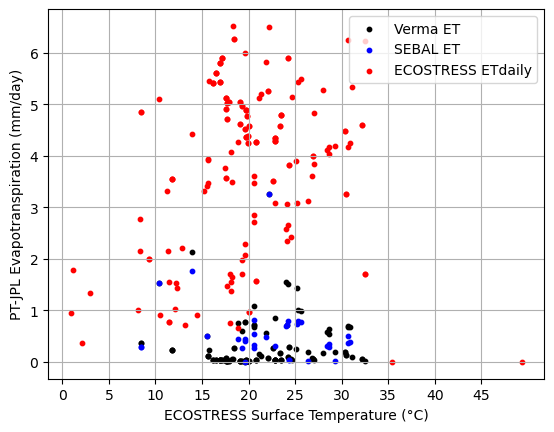

In [90]:
plt.xticks(range(int(min(processed.ST_C)), int(max(processed.ST_C)) + 1, 5))
plt.scatter(x=processed.ST_C, y=processed.ET, color='black', s=10, label="Verma ET")
plt.scatter(x=processed_sebal.ST_C, y=processed_sebal.ET, color='blue', s=10, label="SEBAL ET")
plt.scatter(x=processed.ST_C, y=processed.ETdaily, color='red', s=10, label="ECOSTRESS ETdaily")
plt.grid(True, zorder=0)
plt.legend(loc='upper right')
plt.xlabel("ECOSTRESS Surface Temperature (°C)")
plt.ylabel("PT-JPL Evapotranspiration (mm/day)")
plt.show()

In [91]:
if "Ta" in input_df and "Ta_C" not in input_df:
    # input_df.rename({"Ta": "Ta_C"}, inplace=True)
    input_df["Ta_C"] = input_df["Ta"]

input_df = input_df[input_df.fAPARmax.apply(lambda fAPARmax: fAPARmax > 0.001)]
input_df = input_df[input_df.NDVI.apply(lambda NDVI: NDVI > 0.05)]

np.nanmin(input_df.ST_C), np.nanmax(input_df.ST_C)

(0.89, 49.33)

In [92]:
input_df = input_df[~input_df.Rn.isna()]

In [93]:
processed = process_verma_PTJPL_table(input_df)
input_df = input_df[processed.Rn !=0]

In [94]:
input_variable = ["ST_C", "NDVI", "albedo", "Ta_C", "RH"]
input_uncertainty = np.array([1.0, 0.05, 0.01, 1.0, 0.02])
output_variable = ["LE"]

unperturbed_input, perturbed_input_df, perturbed_output_df, results = joint_perturbed_run(
    input_df=input_df, 
    input_variable=input_variable, 
    output_variable=output_variable, 
    forward_process=process_verma_PTJPL_table,
    perturbation_mean=np.zeros(5),
    perturbation_cov=np.eye(5) * input_uncertainty ** 2,
    dropna=False
)

100000


/Users/Maggiej/Documents/GitHub/ET-Sensitivity/vegetation_conversion/vegetation_conversion.py:45: RuntimeWarning: divide by zero encountered in log
  LAI = rt.clip(-np.log(1 - fIPAR) * (1 / KPAR), min_LAI, max_LAI)


In [95]:
ids = results["id"][perturbed_output_df["LE"] != 0]

In [96]:
repeat_input_df = repeat_rows(input_df,1000)
repeat_input_df = repeat_input_df[perturbed_output_df["LE"] != 0]

repeat_verma_df = process_verma_PTJPL_table(repeat_input_df)
repeat_verma_df['Rn'] = repeat_verma_df['Rn'].astype(float) 
repeat_verma_df['LE'] = repeat_verma_df['LE'].astype(float) 
repeat_verma_df['doy'] = repeat_verma_df['doy'].astype(float) 
repeat_verma_df['lat'] = repeat_verma_df['lat'].astype(float) 
repeat_verma_df['hour_of_day'] = repeat_verma_df['hour_of_day'].astype(float) 

true_df = process_daily_ET_table(repeat_verma_df)
true_df["id"] = ids

In [97]:
perturbed_input_df = perturbed_input_df[perturbed_output_df["LE"] != 0]
perturbed_output_df = perturbed_output_df[perturbed_output_df["LE"] != 0]

In [98]:
perturbed_output_df['doy'] = perturbed_output_df['doy'].astype(float) 
perturbed_output_df['lat'] = perturbed_output_df['lat'].astype(float) 
perturbed_output_df['hour_of_day'] = perturbed_output_df['hour_of_day'].astype(float) 
perturbed_ET_results = process_daily_ET_table(perturbed_output_df)
perturbed_ET_results["id"] = ids

In [99]:
perturbed_input_df['doy'] = perturbed_input_df['doy'].astype(float) 
perturbed_input_df['lat'] = perturbed_input_df['lat'].astype(float) 
perturbed_input_df['hour_of_day'] = perturbed_input_df['hour_of_day'].astype(float) 
perturbed_input_df["NDVI"] = repeat_input_df.NDVI
perturbed_output_df_NDVI = process_verma_PTJPL_table(perturbed_input_df)
perturbed_ET_results_NDVI = process_daily_ET_table(perturbed_output_df_NDVI)
perturbed_ET_results_NDVI["id"] = ids

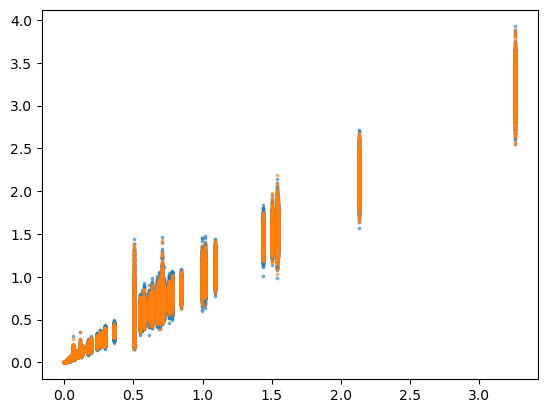

In [100]:
# plt.hist(perturbed_ET_results.ET)
# plt.hist(true_df.ET)
plt.scatter(x=true_df.ET, y=perturbed_ET_results.ET,label="All Variables", alpha=0.5, s=3)
plt.scatter(x=true_df.ET, y=perturbed_ET_results_NDVI.ET,label="True NDVI", alpha=0.5, s=3)

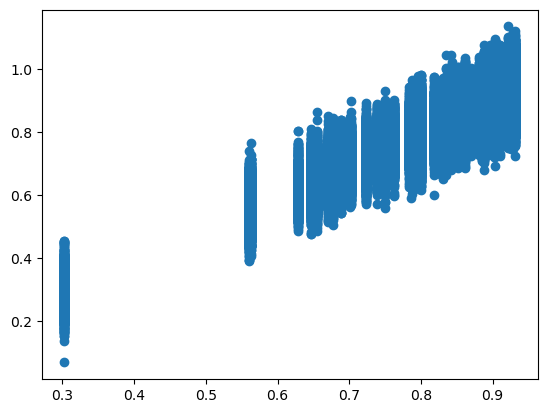

In [103]:
plt.scatter(x=perturbed_output_df_NDVI.NDVI, y=perturbed_output_df.NDVI)

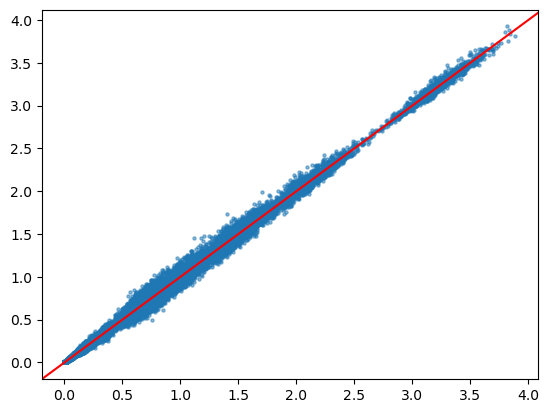

In [108]:
plt.scatter(x=perturbed_ET_results_NDVI.ET, y=perturbed_ET_results.ET, s=5, alpha=0.5)
plt.axline((0, 0), slope=1, c="red")
# plt.hist(true_df.ET,alpha=0.5)

(array([1.10000e+01, 7.40000e+01, 7.26000e+02, 7.16600e+03, 1.20217e+05,
        3.82800e+03, 5.04000e+02, 1.03000e+02, 3.10000e+01, 1.00000e+01]),
 array([-0.71445729, -0.54985532, -0.38525336, -0.22065139, -0.05604942,
         0.10855255,  0.27315452,  0.43775649,  0.60235846,  0.76696042,
         0.93156239]),
 <BarContainer object of 10 artists>)

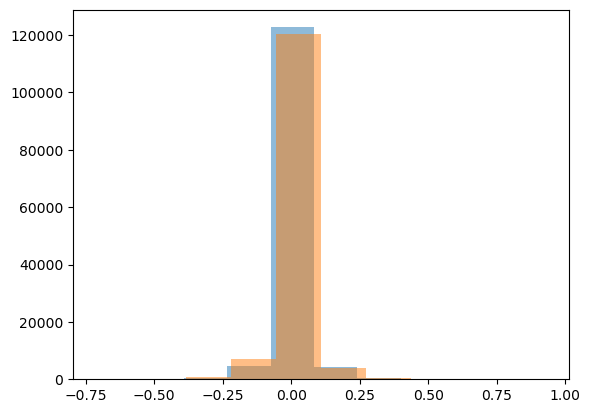

In [ ]:
plt.hist(perturbed_ET_results_NDVI.ET - true_df.ET, alpha=0.5)
plt.hist(perturbed_ET_results.ET - true_df.ET, alpha=0.5)


In [112]:
results_list = [y for x, y in perturbed_ET_results.groupby('id')]
results_ndvi_true_list = [y for x, y in perturbed_ET_results_NDVI.groupby('id')]

sd_vars = [np.nanstd(y.ET,axis=0) for y in results_list]
ndvi_vars = [np.nanmean(y.NDVI,axis=0) for y in results_list]

sd_true_vars = [np.nanstd(y.ET,axis=0) for y in results_ndvi_true_list]

prop_var = np.divide(np.array(sd_true_vars)**2, np.array(sd_vars)**2)

/var/folders/mn/p7nlmtw91vz64gy8rcrtrpgm0000gq/T/ipykernel_44069/478358877.py:9: RuntimeWarning: invalid value encountered in divide
  prop_var = np.divide(np.array(sd_true_vars)**2, np.array(sd_vars)**2)


In [113]:
prop_var

array([0.83805005, 0.78762816, 1.00594591, 0.84620977, 0.78443245,
       0.877569  , 0.76428531, 0.78576203, 0.85356931,        nan,
       0.44064656, 0.53519909, 0.78274173, 0.43342287, 0.47983722,
       0.99570762, 0.79825235, 0.63288747, 0.71935605, 0.42446216,
       0.41531296, 0.49394371, 0.42513438, 0.66518895, 0.68606616,
       0.63960629, 0.63773324, 0.40178434, 0.39350398, 0.40776659,
       0.40297704, 0.44102771, 0.39123725, 0.44610037, 0.41820814,
       0.49117641, 0.51615103, 0.44405801, 0.50809036, 0.54260321,
       0.53012703, 0.54451867, 0.61009444, 0.55576431, 0.60360635,
       0.60847468, 0.62277969, 0.53116593, 0.4212929 , 0.83557171,
       0.87073983, 0.98884178, 0.71634913, 0.72477659, 0.75714656,
       0.45223157, 0.45401543, 0.49647626, 0.462397  , 0.53397212,
       0.51846799, 0.52030392, 0.53746791, 0.6668153 , 0.6035252 ,
       0.58295513, 0.661548  , 0.62017276, 0.59422515, 0.7232593 ,
       0.64926381, 0.64469312, 0.66287476, 0.69040782, 0.66807

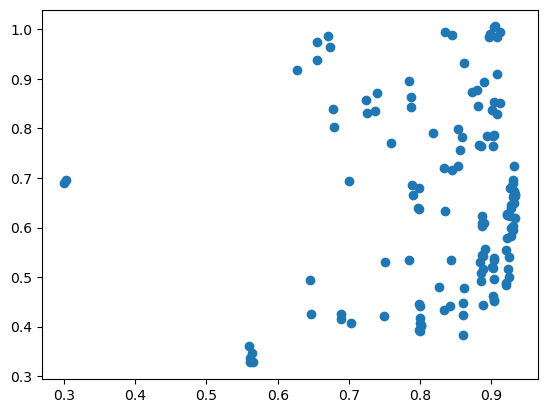

In [114]:
plt.scatter(x=ndvi_vars, y=prop_var)

In [ ]:
np.nanstd(perturbed_ET_results_NDVI.ET - true_df.ET)**2 / np.nanstd(perturbed_ET_results.ET - true_df.ET)**2 ## prop var

0.816675954753387

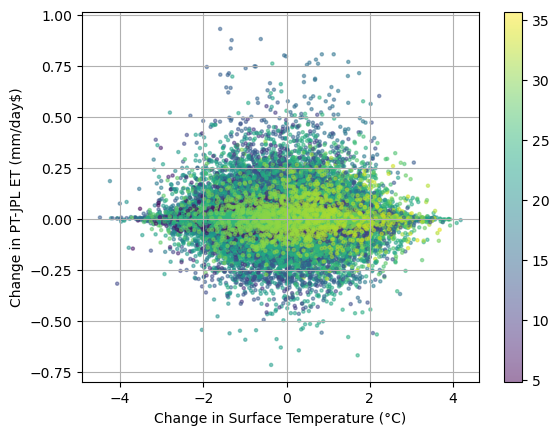

In [126]:
plt.scatter(x=perturbed_ET_results.ST_C - true_df.ST_C, y=perturbed_ET_results.ET - true_df.ET, c=perturbed_ET_results.ST_C, cmap="viridis",s=5, alpha=0.5)  # Adjust the 's' parameter to make dots thinner
plt.grid(True, zorder=0)
plt.colorbar()
plt.xlabel("Change in Surface Temperature (°C)")
plt.ylabel("Change in PT-JPL ET (mm/day$)")
plt.show()

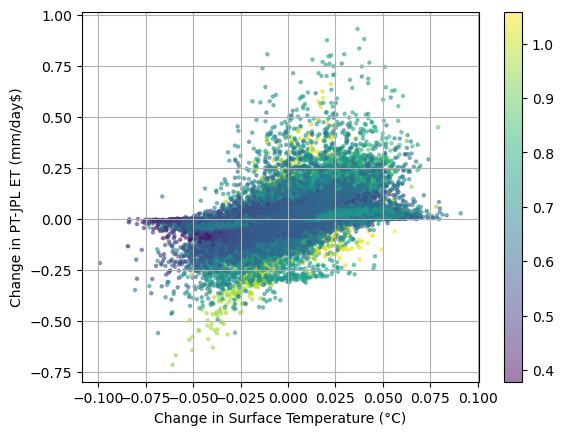

In [127]:
plt.scatter(x=perturbed_ET_results.RH - true_df.RH, y=perturbed_ET_results.ET - true_df.ET, c=perturbed_ET_results.RH, cmap="viridis",s=5, alpha=0.5)  # Adjust the 's' parameter to make dots thinner
plt.grid(True, zorder=0)
plt.colorbar()
plt.xlabel("Change in Surface Temperature (°C)")
plt.ylabel("Change in PT-JPL ET (mm/day$)")
plt.show()

OLD STUFF

In [ ]:
input_variable = ["ST_C", "albedo", "Ta_C", "RH"]
input_uncertainty = np.array([1.0, 0.1, 1, 0.1])
output_variable = ["LE"]

results_NDVI_true = joint_perturbed_run(
    input_df=input_df, 
    input_variable=input_variable, 
    output_variable=output_variable, 
    forward_process=process_verma_PTJPL_table,
    perturbation_mean=np.zeros(4),
    perturbation_cov=np.eye(4) * input_uncertainty ** 2

)

In [66]:
results = results[results.LE_unperturbed != 0]
results_NDVI_true = results_NDVI_true[results_NDVI_true.LE_unperturbed != 0]

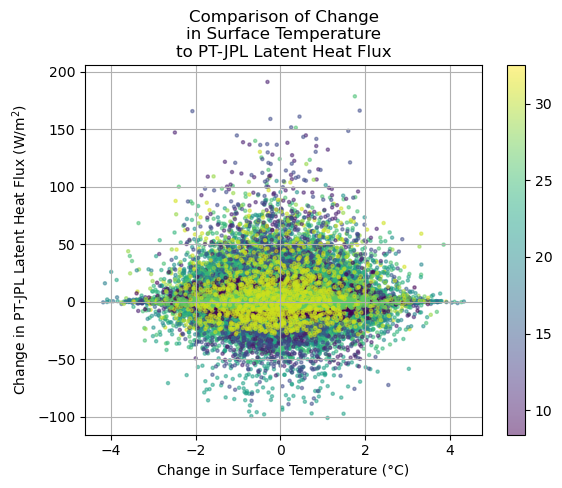

In [73]:
plt.scatter(x=results.ST_C_perturbation, y=results.LE_perturbation, c=results.ST_C_unperturbed, cmap="viridis",s=5, alpha=0.5)  # Adjust the 's' parameter to make dots thinner
plt.grid(True, zorder=0)
plt.colorbar()
plt.xlabel("Change in Surface Temperature (°C)")
plt.ylabel("Change in PT-JPL Latent Heat Flux (W/m$^2$)")
plt.title("Comparison of Change\nin Surface Temperature\nto PT-JPL Latent Heat Flux")
plt.show()

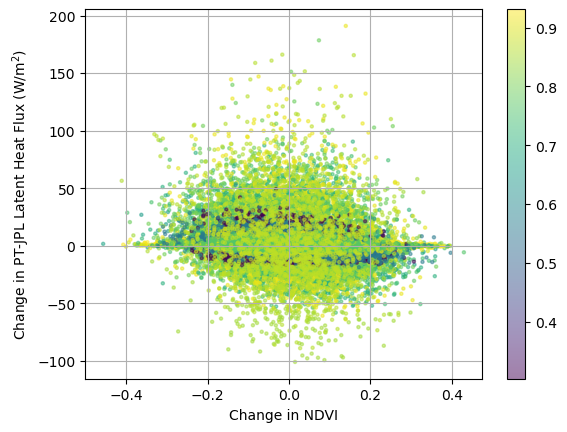

In [74]:
plt.scatter(x=results.NDVI_perturbation, y=results.LE_perturbation, c=results.NDVI_unperturbed, cmap="viridis",s=5, alpha=0.5) # Adjust the 's' parameter to make dots thinner
plt.grid(True, zorder=0)
plt.colorbar()
plt.xlabel("Change in NDVI")
plt.ylabel("Change in PT-JPL Latent Heat Flux (W/m$^2$)")
plt.show()

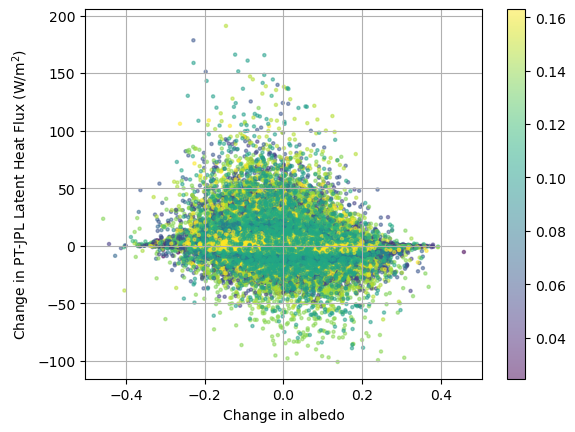

In [75]:
plt.scatter(x=results.albedo_perturbation, y=results.LE_perturbation,  c=results.albedo_unperturbed, cmap="viridis",s=5, alpha=0.5)  # Adjust the 's' parameter to make dots thinner
plt.grid(True, zorder=0)
plt.colorbar()
plt.xlabel("Change in albedo")
plt.ylabel("Change in PT-JPL Latent Heat Flux (W/m$^2$)")
plt.show()

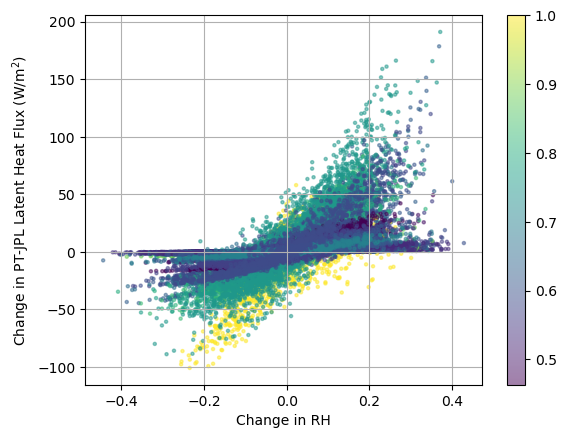

In [76]:
plt.scatter(x=results.RH_perturbation, y=results.LE_perturbation, c=results.RH_unperturbed, cmap="viridis",s=5, alpha=0.5)  # Adjust the 's' parameter to make dots thinner
plt.grid(True, zorder=0)
plt.colorbar()
plt.xlabel("Change in RH")
plt.ylabel("Change in PT-JPL Latent Heat Flux (W/m$^2$)")
plt.show()

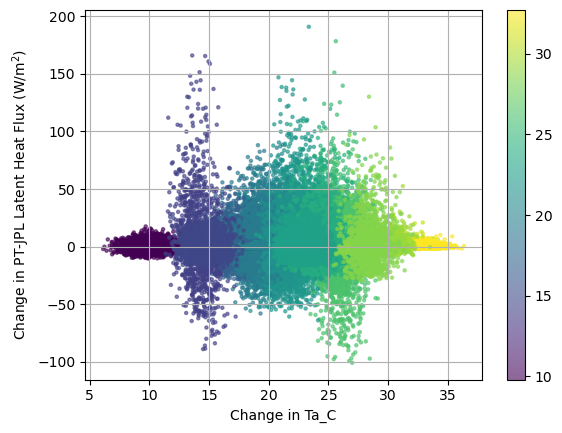

In [77]:
plt.scatter(x=results.Ta_C_perturbed, y=results.LE_perturbation, c=results.Ta_C_unperturbed, cmap="viridis",s=5, alpha=0.6)  # Adjust the 's' parameter to make dots thinner
plt.grid(True, zorder=0)
plt.colorbar()
plt.xlabel("Change in Ta_C")
plt.ylabel("Change in PT-JPL Latent Heat Flux (W/m$^2$)")
plt.show()

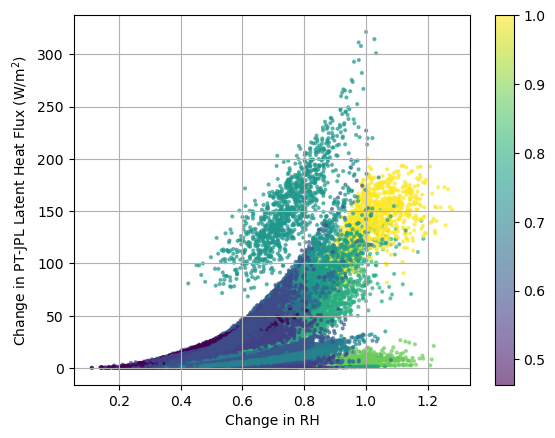

In [78]:
plt.scatter(x=results_NDVI_true.RH_perturbed, y=results_NDVI_true.LE_perturbed, c=results_NDVI_true.RH_unperturbed,s=4, alpha=0.6)  # Adjust the 's' parameter to make dots thinner
plt.grid(True, zorder=0)
plt.colorbar()
plt.xlabel("Change in RH")
plt.ylabel("Change in PT-JPL Latent Heat Flux (W/m$^2$)")
plt.show()

In [79]:
ans = [y for x, y in results.groupby('id')]

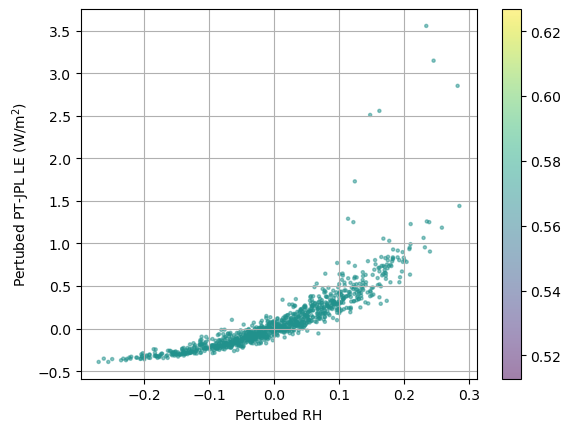

In [80]:
k=4
plt.scatter(x=ans[k].RH_perturbation, y=ans[k].LE_perturbation, c=ans[k].RH_unperturbed,s=5, alpha=0.5)  # Adjust the 's' parameter to make dots thinner
plt.grid(True, zorder=0)
plt.colorbar()
plt.xlabel("Pertubed RH")
plt.ylabel("Pertubed PT-JPL LE (W/m$^2$)")
plt.show()

In [104]:
results_list = [y for x, y in results.groupby('id')]
results_ndvi_true_list = [y for x, y in results_NDVI_true.groupby('id')]

sd_vars = [np.std(y.LE_perturbed,axis=0) for y in results_list]
true_vars = [np.mean(y.LE_unperturbed,axis=0) for y in results_list]

sd_true_vars = [np.std(y.LE_perturbed,axis=0) for y in results_ndvi_true_list]


In [113]:
prop_var = np.divide(np.array(sd_true_vars)**2, np.array(sd_vars)**2)

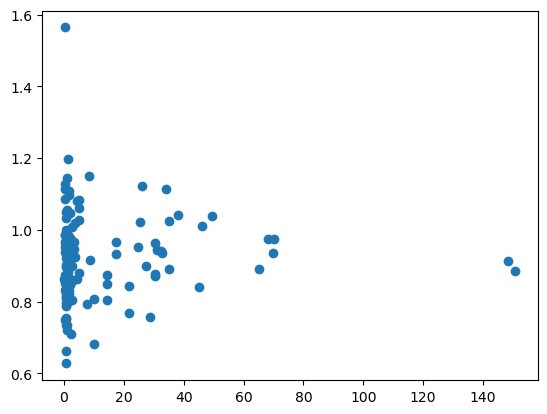

In [ ]:
plt.scatter(x=true_vars, y=prop_var) ## need to keep same perturbations

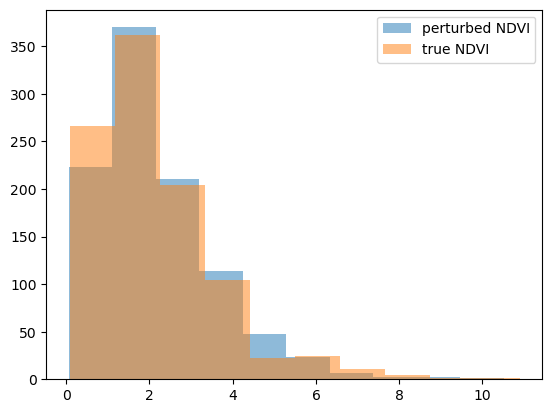

In [102]:
plt.hist(results_list[0].LE_perturbed, alpha=0.5, label="perturbed NDVI")
plt.hist(results_ndvi_true_list[0].LE_perturbed, alpha=0.5, label="true NDVI")
plt.legend()


133

In [18]:
input_variables = ["ST_C", "NDVI", "albedo", "Ta_C", "RH"]
output_variables = ["LE"]

perturbation_df, sensitivity_metrics_df = sensitivity_analysis(
    input_df=input_df,
    input_variables=input_variables,
    output_variables=output_variables,
    forward_process=process_verma_PTJPL_table,
    normalization_function=normalization_function
)

sensitivity_metrics_df

/Users/gregoryhalverson/Projects/ET-Sensitivity/sensitivity/sensitvity.py:161: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perturbation_df = pd.concat([perturbation_df, run_results])
/Users/gregoryhalverson/Projects/ET-Sensitivity/sensitivity/sensitvity.py:179: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sensitivity_metrics_df = pd.concat([sensitivity_metrics_df, pd.DataFrame([[
/Users/gregoryhalverson/Projects/ET-Sensitivity/vegetation_conversion/vegetation_conversion.py:45: RuntimeWarning:

,input_variable,output_variable,metric,value
0,ST_C,LE,correlation,0.785873
0,ST_C,LE,r2,0.617597
0,ST_C,LE,mean_normalized_change,0.037333
0,NDVI,LE,correlation,0.632092
0,NDVI,LE,r2,0.399541
0,NDVI,LE,mean_normalized_change,0.201091
0,albedo,LE,correlation,0.641663
0,albedo,LE,r2,0.411731
0,albedo,LE,mean_normalized_change,0.056511
0,Ta_C,LE,correlation,0.194445


/var/folders/bv/410kt7f93x78j9dww00h1pz80000gn/T/ipykernel_9676/1678908124.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Surface\nTemperature", "NDVI", "Albedo", "Air\nTemperature", "Relative\nHumidity"])


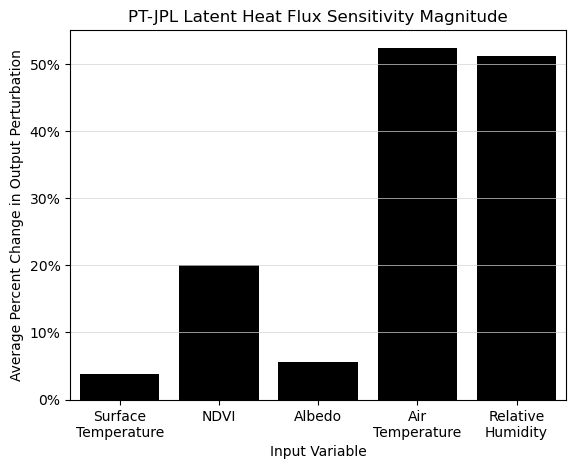

In [28]:
df = sensitivity_metrics_df
df = df[(df.output_variable == "LE") & (df.metric == "mean_normalized_change")]
ax = sns.barplot(x=df.input_variable, y=df.value * 100, color='black')
ax.set_xticklabels(["Surface\nTemperature", "NDVI", "Albedo", "Air\nTemperature", "Relative\nHumidity"])
plt.xlabel("Input Variable")
plt.ylabel("Average Percent Change in Output Perturbation")
plt.title("PT-JPL Latent Heat Flux Sensitivity Magnitude")
# plt.ylim(0, 160)  # Set y-axis range from 0 to 160
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5)  # Add light gray horizontal gridlines only

# Add percent sign to y-axis tick labels
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))

plt.savefig("PT-JPL Latent Heat Flux Sensitivity Magnitude.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("PT-JPL Latent Heat Flux Sensitivity Magnitude.svg", format='svg', bbox_inches='tight')

plt.show()

/var/folders/bv/410kt7f93x78j9dww00h1pz80000gn/T/ipykernel_9676/2265298213.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Surface\nTemperature", "NDVI", "Albedo", "Air\nTemperature", "Relative\nHumidity"])


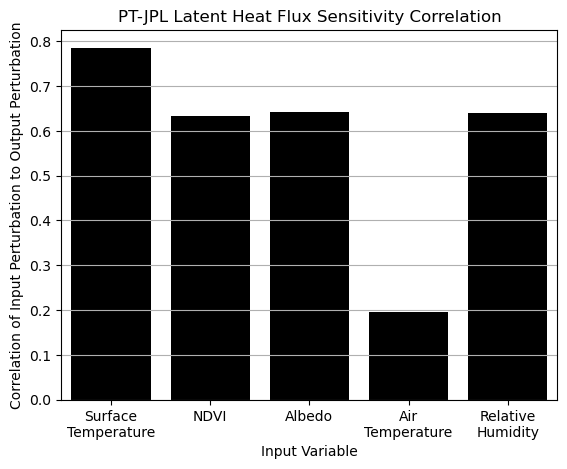

In [27]:
df = sensitivity_metrics_df
df = df[(df.output_variable == "LE") & (df.metric == "correlation")]
ax = sns.barplot(x=df.input_variable, y=df.value, color='black')
ax.set_xticklabels(["Surface\nTemperature", "NDVI", "Albedo", "Air\nTemperature", "Relative\nHumidity"])
# plt.ylim(0, 0.8)
plt.xlabel("Input Variable")
plt.ylabel("Correlation of Input Perturbation to Output Perturbation")
plt.title("PT-JPL Latent Heat Flux Sensitivity Correlation")
plt.grid(axis='y')  # Add horizontal gridlines

plt.savefig("PT-JPL Latent Heat Flux Sensitivity Correlation.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("PT-JPL Latent Heat Flux Sensitivity Correlation.svg", format='svg', bbox_inches='tight')

plt.show()